# Comparing Skin Care Products by Ingredients

Buying skin care products can be intimidating. With so many products out there all claiming to improve your skin it can be difficult to determine which products are right for you.

The ironic thing is that all the information needed is on the back of each product: the ingredient list. But it's <b>tought</b> to interpret those ingredient lists unless you have a background in chemistry. After all, knowledge is power right? This is where data science can help you determine which products may be a good fit. 

In this project, I created a content-based recommendation system where the 'content' is the chemical components of cosmetics. Specifically, I processed ingredient lists for 1472 cosmetics on Sephora via word embedding, then visualized ingredient similarity using a machine learning method called t-SNE and an interactive visualization library called Bokeh.

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE 
from scipy.spatial.distance import cdist

# Load the data
df = pd.read_csv("./data/skincare_products.csv")

# Check the first five rows 
display(df.head())

# Inspect the types of products
display(df['product_type'].value_counts())

,product_name,product_url,product_type,ingredients,price
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"Aqua (Water), Caprylic/Capric Triglyceride, Ce...",£5.20
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"Aqua/Water, Homosalate, Glycerin, Octocrylene,...",£13.00
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...",£6.20
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"Aqua/Water/Eau, Ammonium Lactate, C12-15 Alkyl...",£22.50
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"Purified Water, Glycerin, Ceteareth-20 and Cet...",£16.00


product_type
Mask           124
Body Wash      123
Moisturiser    115
Cleanser       115
Serum          113
Eye Care       100
Mist            80
Oil             76
Toner           73
Balm            61
Exfoliator      57
Bath Salts      36
Bath Oil        33
Peel            32
Name: count, dtype: int64

In [4]:
df.shape

(1138, 5)

## Focus on one product category and one skin type

There are six <b>categories</b> of skin care products in the data: 

- Moisturizer
- Cleanser
- Face mask
- Treatment
- Eye cream
- Sun protection

And there are 5 different <b>skin types</b>:

- combination
- dry, normal
- oily
- sensitive

Because individuals have different product needs as well as different skin types, let's set up our workflow so its outputs (a t-SNE model and a visualization of that model) can be customized.

For the example in this notebook, let's focus in on moisturizers for those with dry skin by filtering the data accordingly.

In [22]:
# Filter für Moisturiser
moisturizers = df[df['product_type'] == 'Moisturiser']

# Index zurücksetzen
moisturizers_subset = moisturizers.reset_index(drop=True)

# Ergebnis anzeigen
print(moisturizers_subset)

                                          product_name  \
0    The Ordinary Natural Moisturising Factors + HA...   
1        CeraVe Facial Moisturising Lotion SPF 25 52ml   
2    The Ordinary Hyaluronic Acid 2% + B5 Hydration...   
3            AMELIORATE Transforming Body Lotion 200ml   
4                       CeraVe Moisturising Cream 454g   
..                                                 ...   
110  Mama Mio The Tummy Rub Butter 120ml - Lavender...   
111  Neal's Yard Remedies Vitamin E and Avocado Nig...   
112  First Aid Beauty Ultra Repair Face Moisturiser...   
113                   Bioderma Hydrabio Gel Cream 40ml   
114  Estée Lauder NightWear Plus Anti-Oxidant Night...   

                                           product_url product_type  \
0    https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser   
1    https://www.lookfantastic.com/cerave-facial-mo...  Moisturiser   
2    https://www.lookfantastic.com/the-ordinary-hya...  Moisturiser   
3    https://www.lo

In [23]:
cleansers.head()

,product_name,product_url,product_type,ingredients,price
701,CeraVe Hydrating Cleanser 236ml,https://www.lookfantastic.com/cerave-hydrating...,Cleanser,"Aqua/Water, Glycerin, Cetearyl Alcohol, Phenox...",£9.50
702,CeraVe Hydrating Cleanser 473ml,https://www.lookfantastic.com/cerave-hydrating...,Cleanser,"Aqua/Water, Glycerin, Cetearyl Alcohol, Phenox...",£15.00
703,The Ordinary Squalane Cleanser Supersize Exclu...,https://www.lookfantastic.com/the-ordinary-squ...,Cleanser,"Squalane, Aqua (Water), Coco-Caprylate/Caprate...",£14.20
704,CeraVe Foaming Facial Cleanser 473ml,https://www.lookfantastic.com/cerave-foaming-f...,Cleanser,"Aqua / Water, Glycerin, Coco-betaine, Propylen...",£15.00
705,CeraVe Smoothing Cleanser 236ml,https://www.lookfantastic.com/cerave-smoothing...,Cleanser,"Aqua/Water, Sodium Lauroyl Sarcosinate, Cocami...",£12.00


# 3. Tokenizing the ingredients

To get to our end goal of comparing ingredients in each product, we first need to do some preprocessing tasks and bookkeeping of the actual words in each product's ingredients list. The first step will be tokenizing the list of ingredients in Ingredients column. After splitting them into tokens, we'll make a binary bag of words. Then we will create a dictionary with the tokens, ingredient_idx, which will have the following format:

{ <b>"ingredient"</b>: index value, … }

In [27]:
# Initialize dictionary, list, and initial index
ingredient_idx = {}
corpus = []
idx = 0

# For loop for tokenization
for i in range(len(moisturizers_subset)):    
    ingredients = moisturizers_subset['ingredients'][i]
    ingredients_lower = ingredients.lower()
    tokens = ingredients_lower.split(', ')
    corpus.append(tokens)
    for ingredient in tokens:
        if ingredient not in ingredient_idx:
            ingredient_idx[ingredient] = idx
            idx += 1
            


# 4. Initializing a document-term matrix (DTM)

The next step is making a document-term matrix (DTM). Here each cosmetic product will correspond to a document, and each chemical composition will correspond to a term. This means we can think of the matrix as a “cosmetic-ingredient” matrix.

To create this matrix, we'll first make an empty matrix filled with zeros. The length of the matrix is the total number of cosmetic products in the data. The width of the matrix is the total number of ingredients. After initializing this empty matrix, we'll fill it in the following tasks.

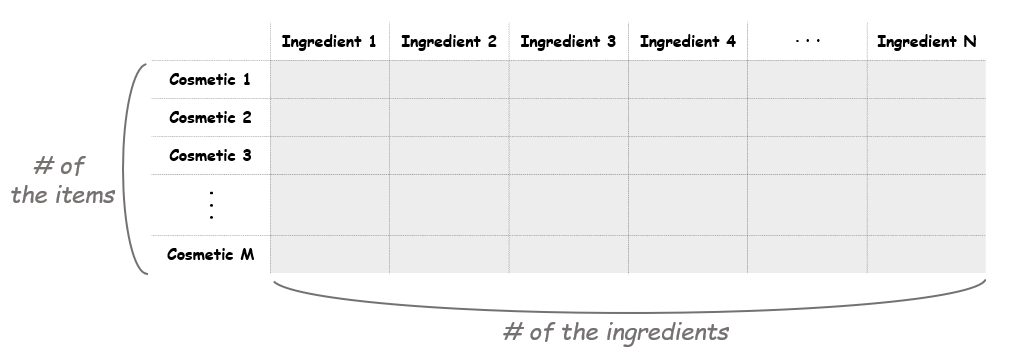

In [28]:
from IPython.display import Image
from PIL import Image


path="./data/image_1.jpg"
display(Image.open(path))

In [29]:
# Get the number of items and tokens 
M = len(moisturizers_subset)
N = len(ingredient_idx)

# Initialize a matrix of zeros
A = np.zeros((M,N))

In [30]:
A.shape

(115, 1023)

# 5. Creating a counter function

Before we can fill the matrix, let's create a function to count the tokens (i.e., an ingredients list) for each row. Our end goal is to fill the matrix with 1 or 0: if an ingredient is in a cosmetic, the value is 1. If not, it remains 0. The name of this function, oh_encoder, will become clear next.

In [31]:
# Define the oh_encoder function
def oh_encoder(tokens):
    x = np.zeros(N)
    for ingredient in tokens:
        # Get the index for each ingredient
        idx = ingredient_idx[ingredient]
        # Put 1 at the corresponding indices
        x[idx] = 1
    return x

# 6. The Cosmetic-Ingredient matrix!

Now we'll apply the oh_encoder() functon to the tokens in corpus and set the values at each row of this matrix. So the result will tell us what ingredients each item is composed of. For example, if a cosmetic item contains water, niacin, decyl aleate and sh-polypeptide-1, the outcome of this item will be as follows.

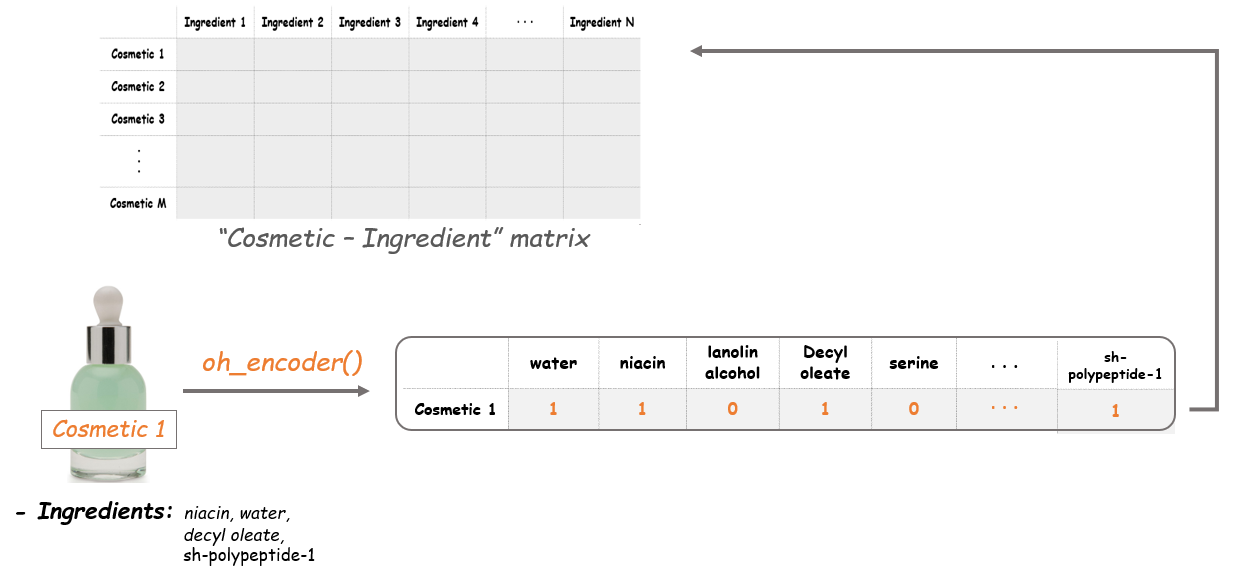

In [32]:
path="./data/image_2.jpg"
display(Image.open(path))

This is what we called one-hot encoding. By encoding each ingredient in the items, the Cosmetic-Ingredient matrix will be filled with binary values

In [33]:
# Make a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = oh_encoder(tokens)
    i +=1

In [34]:
A.shape

(115, 1023)

In [35]:
A

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.]])

# 7. Dimension reduction with t-SNE

The dimensions of the existing matrix is (190, 2233), which means there are 2233 features in our data. For visualization, we should downsize this into two dimensions. We'll use t-SNE for reducing the dimension of the data here.

<b>T-distributed Stochastic Neighbor Embedding (t-SNE)</b> is a nonlinear dimensionality reduction technique that is well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, this technique can reduce the dimension of data while keeping the similarities between the instances. This enables us to make a plot on the coordinate plane, which can be said as vectorizing. All of these cosmetic items in our data will be vectorized into two-dimensional coordinates, and the distances between the points will indicate the similarities between the items.

In [36]:
# Dimension reduction with t-SNE
model = TSNE(n_components = 2, learning_rate = 200, random_state = 42)
tsne_features = model.fit_transform(A)

# Make X, Y columns 
moisturizers_subset['X'] = tsne_features[:, 0]
moisturizers_subset['Y'] = tsne_features[:, 1]

In [37]:
moisturizers_subset.head()

,product_name,product_url,product_type,ingredients,price,X,Y
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"Aqua (Water), Caprylic/Capric Triglyceride, Ce...",£5.20,305.296082,-29.875544
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"Aqua/Water, Homosalate, Glycerin, Octocrylene,...",£13.00,95.929573,-126.191971
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...",£6.20,-78.474052,43.328705
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"Aqua/Water/Eau, Ammonium Lactate, C12-15 Alkyl...",£22.50,-260.359680,-44.922817
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"Purified Water, Glycerin, Ceteareth-20 and Cet...",£16.00,153.737732,170.330002


# Find similar products

In [51]:
target = moisturizers_subset[moisturizers_subset['product_name'] == 'The Ordinary Natural Moisturising Factors + HA 30ml']
target

,product_name,product_url,product_type,ingredients,price,X,Y,distance
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"Aqua (Water), Caprylic/Capric Triglyceride, Ce...",£5.20,305.296082,-29.875544,[[0.0]]


In [40]:
x  = target['X'].values[0]
y = target['Y'].values[0]
print(x, y)

305.29608 -29.875544


In [41]:
df1 = pd.DataFrame()
df1['point'] = [(x, y) for x,y in zip(moisturizers_subset['X'], moisturizers_subset['Y'])]

df1.head()


,point
0,"(305.29608154296875, -29.87554359436035)"
1,"(95.92957305908203, -126.19197082519531)"
2,"(-78.47405242919922, 43.328704833984375)"
3,"(-260.35968017578125, -44.92281723022461)"
4,"(153.73773193359375, 170.3300018310547)"


In [42]:
point = np.array([[x,y]])

point.shape

(1, 2)

In [43]:
cdist(point, np.array([[-9.456123352050781, 16.348276138305664]]), metric='euclidean')

array([[318.12826344]])

In [44]:
moisturizers_subset['distance'] = [cdist(np.array([[x,y]]), np.array([product]), metric='euclidean') for product in df1['point']]

In [45]:
moisturizers_subset.head()

,product_name,product_url,product_type,ingredients,price,X,Y,distance
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"Aqua (Water), Caprylic/Capric Triglyceride, Ce...",£5.20,305.296082,-29.875544,[[0.0]]
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"Aqua/Water, Homosalate, Glycerin, Octocrylene,...",£13.00,95.929573,-126.191971,[[230.45864928278593]]
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...",£6.20,-78.474052,43.328705,[[390.68961813308346]]
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"Aqua/Water/Eau, Ammonium Lactate, C12-15 Alkyl...",£22.50,-260.359680,-44.922817,[[565.8558661085806]]
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"Purified Water, Glycerin, Ceteareth-20 and Cet...",£16.00,153.737732,170.330002,[[251.10195888404667]]


In [46]:
# arrange by descending order
top_matches = moisturizers_subset.sort_values(by=['distance'])
top_matches.head(5)

,product_name,product_url,product_type,ingredients,price,X,Y,distance
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"Aqua (Water), Caprylic/Capric Triglyceride, Ce...",£5.20,305.296082,-29.875544,[[0.0]]
7,The Ordinary Natural Moisturizing Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"Aqua (Water), Caprylic/Capric Triglyceride, Ce...",£6.80,289.394226,-18.556398,[[19.519017789514617]]
58,The INKEY List Multi-Biotic Moisturiser 30ml,https://www.lookfantastic.com/the-inkey-list-m...,Moisturiser,"Aqua (Water), Inulin, Glycerin, Isoamyl Laurat...",£12.99,208.705307,-42.755722,[[97.4457629783538]]
102,Estée Lauder DayWear Anti-Oxidant 72H-Hydratio...,https://www.lookfantastic.com/estee-lauder-day...,Moisturiser,"Water/Aqua/Eau, Glycerin, Alcohol Denat., Ethy...",£40.50,209.947678,20.067329,[[107.63646545538803]]
77,NIOD Hydration Vaccine Face Cream 50ml,https://www.lookfantastic.com/niod-hydration-v...,Moisturiser,"Caprylyl Methicone, Aqua (Water), PEG-12 Dimet...",£35.00,238.040695,79.571907,[[128.46023293045505]]


In [48]:
top_matches = top_matches[['product_type', 'product_name', 'price', 'ingredients', 'distance']]
top_matches = top_matches.reset_index()
top_matches = top_matches.drop(top_matches.index[0])
top_matches.head()


,index,product_type,product_name,price,ingredients,distance
1,7,Moisturiser,The Ordinary Natural Moisturizing Factors + HA...,£6.80,"Aqua (Water), Caprylic/Capric Triglyceride, Ce...",[[19.519017789514617]]
2,58,Moisturiser,The INKEY List Multi-Biotic Moisturiser 30ml,£12.99,"Aqua (Water), Inulin, Glycerin, Isoamyl Laurat...",[[97.4457629783538]]
3,102,Moisturiser,Estée Lauder DayWear Anti-Oxidant 72H-Hydratio...,£40.50,"Water/Aqua/Eau, Glycerin, Alcohol Denat., Ethy...",[[107.63646545538803]]
4,77,Moisturiser,NIOD Hydration Vaccine Face Cream 50ml,£35.00,"Caprylyl Methicone, Aqua (Water), PEG-12 Dimet...",[[128.46023293045505]]
5,92,Moisturiser,Clinique for Men Oil-Control Moisturiser 100ml,£25.50,"Water\Aqua\Eau, Isododecane, Butylene Glycol, ...",[[137.29512087952594]]


In [ ]:
cosmetic_1 = moisturizers_subset[moisturizers_subset['Name'] == "The Moisturizing Soft Cream"]
cosmetic_2 = moisturizers_subset[moisturizers_subset['Name'] == "Moisture Surge Hydrating Supercharged Concentrate"]

In [49]:
# Display each item's data and ingredients
display(cosmetic_1)
print(cosmetic_1.Ingredients.values)
display(cosmetic_2)
print(cosmetic_2.Ingredients.values)

NameError: name 'cosmetic_1' is not defined

In [ ]:
c1 = cosmetic_1.Ingredients.values
c2 = cosmetic_2.Ingredients.values

In [50]:
# make list of ingredients
c1_list = c1[0].split(",")
c2_list = c2[0].split(",")

# strip spaces
c1_list = [x.strip(' ') for x in c1_list]
c2_list = [x.strip(' ') for x in c2_list]

NameError: name 'c1' is not defined

In [ ]:
# turn lists into sets for comparison
c1_set = set(c1_list)
c2_set = set(c2_list)

In [ ]:
# get same ingredients
same_ingredients = c2_set.intersection(c1_set)
print(same_ingredients)

{'Phenoxyethanol', 'Water', 'Caffeine', 'Sodium Hyaluronate', 'Phenyl Trimethicone', 'Tocopheryl Acetate', 'Disodium Edta', 'Tetrahexyldecyl Ascorbate', 'Sucrose', 'Glycerin', 'Cholesterol', 'Butylene Glycol', 'Trehalose', 'Bht'}


In [ ]:
top_matches['Ingredients in common'] = [c1_set.intersection( set([x.strip(' ')for x in product.split(",")]) ) for product in top_matches['Ingredients']]
top_matches.head(5)

,index,Label,Brand,Name,Price,Ingredients,distance,Ingredients in common
1,1,Moisturizer,CLINIQUE,Moisture Surge Hydrating Supercharged Concentrate,39,"Water , Glycerin , Butylene Glycol , Phenyl Tr...",[[15.169489902549909]],"{Phenoxyethanol, Water, Caffeine, Sodium Hyalu..."
2,2,Moisturizer,DR. BRANDT SKINCARE,Do Not Age with Dr. Brandt Moisturizing Neck C...,67,"Water, Caprylic/Capric Triglyceride, Squalane,...",[[16.22201861575024]],"{Phenoxyethanol, Pentylene Glycol, Water, Sodi..."
3,3,Moisturizer,BOBBI BROWN,Vitamin Enriched Face Base Priming Moisturizer,60,"Water, Cyclopentasiloxane, Bis-Diglyceryl Poly...",[[21.55760959898158]],"{Cyclopentasiloxane, Linalool, Phenoxyethanol,..."
4,4,Moisturizer,CLINIQUE,Moisture Surge 72-Hour Auto-Replenishing Hydrator,39,"Water , Dimethicone , Butylene Glycol , Glycer...",[[24.39155036027379]],"{Phenoxyethanol, Dimethicone, Water, Caffeine,..."
5,5,Moisturizer,J.ONE,Jelly Pack,42,"Water, Polysorbate 80, PEG-150 Disterate, Niac...",[[24.799514957648242]],"{Phenoxyethanol, Dimethicone, Water, Glycerin,..."


# 8. Let's map the items with Bokeh

We are now ready to start creating our plot. With the t-SNE values, we can plot all our items on the coordinate plane. And the coolest part here is that it will also show us the name, the brand, the price and the rank of each item. Let's make a scatter plot using Bokeh and add a hover tool to show that information. Note that we won't display the plot yet as we will make some more additions to it.

In [ ]:
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()

# Make a source and a scatter plot  
source = ColumnDataSource(moisturizers_subset)
plot = figure(x_axis_label = 'T-SNE 1', 
              y_axis_label = 'T-SNE 2', 
              width = 500, height = 400)
plot.circle(x = 'X', 
    y = 'Y', 
    source = source, 
    size = 10, color = '#FF7373', alpha = .8)

# 9. Adding a hover tool

Why don't we add a hover tool? Adding a hover tool allows us to check the information of each item whenever the cursor is directly over a glyph. We'll add tooltips with each product's name, brand, price, and rank (i.e., rating).

In [ ]:
# Create a HoverTool object
hover = HoverTool(tooltips = [('Item', '@Name'),
                              ('Brand', '@Brand'),
                              ('Price', '$@Price'),
                              ('Rank', '@Rank')])
plot.add_tools(hover)

# 10. Mapping the cosmetic items

Finally, it's show time! Let's see how the map we've made looks like. Each point on the plot corresponds to the cosmetic items. Then what do the axes mean here? The axes of a t-SNE plot aren't easily interpretable in terms of the original data. Like mentioned above, t-SNE is a visualizing technique to plot high-dimensional data in a low-dimensional space. Therefore, it's not desirable to interpret a t-SNE plot quantitatively.
Instead, what we can get from this map is the distance between the points (which items are close and which are far apart). The closer the distance between the two items is, the more similar the composition they have. Therefore this enables us to compare the items without having any chemistry background.

In [ ]:
# Plot the map
show(plot)

# 11. Comparing two products

Since there are so many cosmetics and so many ingredients, the plot doesn't have many super obvious patterns that simpler t-SNE plots can have. Our plot requires some digging to find insights, but that's okay!

Say we enjoyed a specific product, there's an increased chance we'd enjoy another product that is similar in chemical composition. Say we enjoyed AmorePacific's Color Control Cushion Compact Broad Spectrum SPF 50+. We could find this product on the plot and see if a similar product(s) exist. And it turns out it does! If we look at the points furthest left on the plot, we see LANEIGE's BB Cushion Hydra Radiance SPF 50 essentially overlaps with the AmorePacific product. By looking at the ingredients, we can visually confirm the compositions of the products are similar (though it is difficult to do, which is why we did this analysis in the first place!), plus LANEIGE's version is $22 cheaper and actually has higher ratings.

It's not perfect, but it's useful. In real life, we can actually use our little ingredient-based recommendation engine help us make educated cosmetic purchase choices.

In [ ]:
# Print the ingredients of two similar cosmetics
cosmetic_1 = moisturizers_subset[moisturizers_subset['Name'] == "Color Control Cushion Compact Broad Spectrum SPF 50+"]
cosmetic_2 = moisturizers_subset[moisturizers_subset['Name'] == "BB Cushion Hydra Radiance SPF 50"]

# Display each item's data and ingredients
display(cosmetic_1)
print(cosmetic_1.Ingredients.values)
display(cosmetic_2)
print(cosmetic_2.Ingredients.values)

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y
40,Moisturizer,AMOREPACIFIC,Color Control Cushion Compact Broad Spectrum S...,60,4.0,"Phyllostachis Bambusoides Juice, Cyclopentasil...",1,1,1,1,1,3.359492,20.837294


['Phyllostachis Bambusoides Juice, Cyclopentasiloxane, Cyclohexasiloxane, Peg-10 Dimethicone, Phenyl Trimethicone, Butylene Glycol, Butylene Glycol Dicaprylate/Dicaprate, Alcohol, Arbutin, Lauryl Peg-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Polyhydroxystearic Acid, Sodium Chloride, Polymethyl Methacrylate, Aluminium Hydroxide, Stearic Acid, Disteardimonium Hectorite, Triethoxycaprylylsilane, Ethylhexyl Palmitate, Lecithin, Isostearic Acid, Isopropyl Palmitate, Phenoxyethanol, Polyglyceryl-3 Polyricinoleate, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Disodium Edta, Trimethylsiloxysilicate, Ethylhexyglycerin, Dimethicone/Vinyl Dimethicone Crosspolymer, Water, Silica, Camellia Japonica Seed Oil, Camillia Sinensis Leaf Extract, Caprylyl Glycol, 1,2-Hexanediol, Fragrance, Titanium Dioxide, Iron Oxides (Ci 77492, Ci 77491, Ci77499).']


,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y
49,Moisturizer,LANEIGE,BB Cushion Hydra Radiance SPF 50,38,4.3,"Water, Cyclopentasiloxane, Zinc Oxide (CI 7794...",1,1,1,1,1,3.355602,20.815836


['Water, Cyclopentasiloxane, Zinc Oxide (CI 77947), Ethylhexyl Methoxycinnamate, PEG-10 Dimethicone, Cyclohexasiloxane, Phenyl Trimethicone, Iron Oxides (CI 77492), Butylene Glycol Dicaprylate/Dicaprate, Niacinamide, Lauryl PEG-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Titanium Dioxide (CI 77891 , Iron Oxides (CI 77491), Butylene Glycol, Sodium Chloride, Iron Oxides (CI 77499), Aluminum Hydroxide, HDI/Trimethylol Hexyllactone Crosspolymer, Stearic Acid, Methyl Methacrylate Crosspolymer, Triethoxycaprylylsilane, Phenoxyethanol, Fragrance, Disteardimonium Hectorite, Caprylyl Glycol, Yeast Extract, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Trimethylsiloxysilicate, Polysorbate 80, Disodium EDTA, Hydrogenated Lecithin, Dimethicone/Vinyl Dimethicone Crosspolymer, Mica (CI 77019), Silica, 1,2-Hexanediol, Polypropylsilsesquioxane, Chenopodium Quinoa Seed Extract, Magnesium Sulfate, Calcium Chloride